# Information Retrieval Exercise 2 Notebook


This is the template notebook for Exercise 2. The specification for the exercise and the corresponding Exercise 2 Quiz submission instance are available on the Moodle page of the course.

This exercise builds upon Exercise 1, and assumes that you are now familiar with concepts we have introduced in both the Lab 1 and Exercise 1, including:
 - [PyTerrier operators](https://pyterrier.readthedocs.io/en/latest/operators.html)
 - [Pyterrier apply transformers](https://pyterrier.readthedocs.io/en/latest/transformer.html)
 - [PyTerrier pt.Experiment()](https://pyterrier.readthedocs.io/en/latest/experiments.html)


## PyTerrier Setup

First, let's install PyTerrier as usual. We require a specific version of LightGBM. Do not change this version - if you are running locally on Apple Silicon, this wont work, and you should move back to Google Colab.

In [1]:
%pip install -q python-terrier lightgbm==2.2.3 pyterrier-caching

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.4/163.4 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.0/859.0 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.9/287.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 1.2 MB/s eta 0:00:00


Let's start PyTerrier

In [2]:
import pyterrier as pt

# we require a specific version of LightGBM for this exercise
import lightgbm
assert lightgbm.__version__ == '2.2.3'

We're going to speed things up for you by caching the PL2 results and the standard feature set.

DO NOT be tempted to cache your own feature implementations.

In [3]:
from pyterrier_caching import RetrieverCache, SparseScorerCache

CACHE=True

## Index, Topics & Qrels for Exercise 2

You will need your login & password credentials from Exercise 1. We will be using again the "50pct" and the "trec-wt-2004" datasets from Exercise 1.


In [4]:
UNAME="3048044h"
PWORD="b5149a64"

# we will again be using the "50pct" and "trec-wt-2004" datasets
Fiftypct = pt.get_dataset("50pct",  user=UNAME, password=PWORD)
dotgov_topicsqrels = pt.get_dataset("trec-wt-2004")

On the other hand, you will be using a slightly updated index for Exercise 2. It is a bit bigger than the Exercise 1 index, hence it takes about 2-3 minutes to download to Colab.


In [5]:

indexref = Fiftypct.get_index(variant="ex3")
index = pt.IndexFactory.of(indexref, memory=True)


data.meta-0.fsomapfile:   0%|          | 0.00/50.1M [00:00<?, ?iB/s]

data-pagerank.oos:   0%|          | 0.00/9.52M [00:00<?, ?iB/s]

data.direct.bf: 0.00iB [00:00, ?iB/s]

data.document.fsarrayfile:   0%|          | 0.00/19.3M [00:00<?, ?iB/s]

data.inverted.bf:   0%|          | 0.00/384M [00:00<?, ?iB/s]

data.lexicon.fsomapfile:   0%|          | 0.00/183M [00:00<?, ?iB/s]

data.lexicon.fsomaphash:   0%|          | 0.00/0.99k [00:00<?, ?iB/s]

data.lexicon.fsomapid:   0%|          | 0.00/7.80M [00:00<?, ?iB/s]

data.meta.idx:   0%|          | 0.00/6.16M [00:00<?, ?iB/s]

data.meta.zdata:   0%|          | 0.00/861M [00:00<?, ?iB/s]

data.properties:   0%|          | 0.00/3.74k [00:00<?, ?iB/s]

terrier-assemblies 5.11 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started (triggered by IndexFactory.of) and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


Let's check out the new index. Compared to the index we used for Exercise 1, you can see that this index has `Field Names: [TITLE, ELSE]`, which means that we can provide statistics about how many times each term occurs in the title of each document (the "TITLE" field), vs the rest of the document (the "ELSE" field). Refer to Lecture 7 for more information about fields.

Let's also display the keys in the meta index - this is the metadata that we have stored for each document. You can see that we are storing the "url" and the "body" (content) of the document. These will particularly come in handy for Q2 and Q3 of Exercise 2, respectively.


In [6]:
print(index.getCollectionStatistics())
print("In the meta index: " + str(index.getMetaIndex().getKeys()))

Number of documents: 807775
Number of terms: 2043788
Number of postings: 177737957
Number of fields: 2
Number of tokens: 572916194
Field names: [TITLE, ELSE]
Positions:   false

In the meta index: ['docno', 'url', 'title', 'body']


Finally, these are all of the topics and qrels (including the training and validation datasets) that you will need to conduct Exercise 2.

In [7]:
tr_topics = Fiftypct.get_topics("training")
va_topics = Fiftypct.get_topics("validation")

tr_qrels = Fiftypct.get_qrels("training")
va_qrels = Fiftypct.get_qrels("validation")

test_topics = dotgov_topicsqrels.get_topics("hp")
test_qrels = dotgov_topicsqrels.get_qrels("hp")

training.topics:   0%|          | 0.00/7.75k [00:00<?, ?iB/s]

validation.topics:   0%|          | 0.00/4.39k [00:00<?, ?iB/s]

training.qrels:   0%|          | 0.00/2.88k [00:00<?, ?iB/s]

validation.qrels:   0%|          | 0.00/1.48k [00:00<?, ?iB/s]

Web2004.query.stream.trecformat.txt: 0.00iB [00:00, ?iB/s]

04.topic-map.official.txt: 0.00iB [00:00, ?iB/s]

04.qrels.web.mixed.txt: 0.00iB [00:00, ?iB/s]

## Baseline Setup

We introduce here the terrier.Retriever for our baseline. Note that:
 - We are using PL2 as our weighting model to generate the candidate set of documents to re-rank.
 - We expose more document metadata, namely "url" and "body" for each document retrieved, which you will need to deploy your two new features.
 - By setting `verbose=True`, we display a progress bar while retrieval executes.
 - We cache PL2 to make it faster for reuse in later experiments.

In [8]:
firstpass = pt.terrier.Retriever(index, wmodel="PL2", metadata=["docno", "url", "body"], verbose=True)
if CACHE: # wrap in a cache transformer
    firstpass = RetrieverCache('pl2-cache', firstpass)

Let's see the resulting output - you can see that there are now "url" and "body" attributes for each retrieved document. (We also display a progress bar, enabled by the `verbose=True`).

In [9]:
firstpass.search("chemical reactions")

TerrierRetr(PL2): 0q [00:00, ?q/s]

TerrierRetr(PL2):   0%|          | 0/1 [00:00<?, ?q/s]

BitPostingIndex loading /root/.pyterrier/corpora/50pct/index/ex3/data.inverted.bf to memory


,qid,docid,docno,url,body,rank,score,query
0,1,513586,G18-38-1767991,http://www.boulder.nist.gov/div838/tar/file03....,NIST - Physical and Chemical Properties Divi...,0,12.755546,chemical reactions
1,1,38544,G01-14-2537005,http://www.labtrain.noaa.gov/shemtfa/chemhaz/n...,. \r\n \r\n \r\n \...,1,11.906524,chemical reactions
2,1,707122,G26-06-3754605,http://www.aps.anl.gov/xfd/tech/safetyenvelope...,APS Experiment Safety Envelope 6: Chemicals \r...,2,11.877550,chemical reactions
3,1,382754,G13-59-3981168,http://response.restoration.noaa.gov/chemaids/...,"""); }\n else {\n document.wr...",3,11.858475,chemical reactions
4,1,70292,G02-16-2617043,http://www.symp14.nist.gov/PDF/COR04MAY.PDF,A Database of Chemical Reactions Designed to A...,4,11.731490,chemical reactions
...,...,...,...,...,...,...,...,...
995,1,246965,G08-68-4141101,http://en-env.llnl.gov/asd/pinatub.html,The Chemical and Radiative Effects of the Moun...,995,6.290707,chemical reactions
996,1,611136,G22-04-3955177,http://eospso.gsfc.nasa.gov/ftp_docs/Ch7.pdf,Chapter 7\n ...,996,6.289822,chemical reactions
997,1,594957,G21-38-0191596,http://www.oit.doe.gov/news/oittimes/wn02/wn02...,search \r\n\t\t\t\t\t\t\t\t \r\n\t\t\t\t\t\t\...,997,6.287830,chemical reactions
998,1,280944,G09-85-3411646,http://www.ig.doe.gov/pdf/chemfina.pdf,INS-O-00-01\n\n\n\n\n\n\n\n\n I N S P E C T...,998,6.287759,chemical reactions


# Standard List of Features

Let's introduce the list of features we need to deploy a baseline learning-to-rank approach.

We again cache the results of FeaturesRetriever to make it faster.

In [10]:
pagerankfile = indexref + "/data-pagerank.oos"

# DO *NOT* CHANGE THIS LIST. Use PyTerrier operators to add features...
features = [
    "SAMPLE", #ie PL2 - this exposes the scores used to obtain the candidate set as a feature
    "WMODEL:SingleFieldModel(BM25,0)", #BM25 title
    "QI:StaticFeature(OIS,%s)" % pagerankfile,
]

stdfeatures = pt.terrier.FeaturesRetriever(index, features, verbose=True)
if CACHE: # wrap in a cache transformer
    stdfeatures = SparseScorerCache('features-cache', stdfeatures, value="features", pickle=True, verbose=True)

stage12 = firstpass >> stdfeatures

This is our feature set. We will be using FeaturesBatchRetrieve to compute these extra features on the fly. Let's see the output. You can see that there is now a "features" column.

In [11]:
stage12.search("chemical reactions").head(2)

TerrierFeatRetr(3 features):   0%|          | 0/1 [00:00<?, ?q/s]

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

,qid,docid,docno,url,body,rank,score,query,features
0,1,513586,G18-38-1767991,http://www.boulder.nist.gov/div838/tar/file03....,NIST - Physical and Chemical Properties Divi...,0,12.755546,chemical reactions,"[12.755545561073266, 3.0924078763629836, 0.000..."
1,1,38544,G01-14-2537005,http://www.labtrain.noaa.gov/shemtfa/chemhaz/n...,. \r\n \r\n \r\n \...,1,11.906524,chemical reactions,"[11.90652405775751, 10.789390732195702, 0.0002..."


Let's look in more detail at the features. It is clear that there are 3 numbers for each document. The first is the PL2 score (1.27555456e+01 == 12.7555), the second is the BM25 score, and the third is the PageRank (a link analysis feature - discussed in more detail in Lecture 9)

In [12]:
stage12.search("chemical reactions").head(1).iloc[0]["features"]

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

array([1.27555456e+01, 3.09240788e+00, 1.05668333e-04])

# Q1

You now have everyting you need to attempt Q1. You will need to refer to the specification, and to PyTerrier's [learning to rank documentation](https://pyterrier.readthedocs.io/en/latest/ltr.html).

You should use a LightGBM LambdaMART implementation (*not* XGBoost), instantiated using the configuration suggested in the PyTerrier documentation.

Hints:
 - You will need to use the provided separate “training” and “validation” topic sets and qrels to train the learning-to-rank.
 - There is no need to vary the configuration of LightGBM from that in the documentation.
 - Training and evaluating a LTR pipeline takes around 5 minutes.

In [14]:
from scipy.stats import ttest_rel
from pyterrier.measures import P,AP


# LightGBM LambdaMART configuration
lmart_l = lightgbm.LGBMRanker(
    task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10
    )

# Create and train the LTR pipeline
lmart_l_pipe = stage12 >> pt.ltr.apply_learned_model(lmart_l, form="ltr")

lmart_l_pipe.fit(tr_topics, tr_qrels, va_topics, va_qrels)

eval_firstpass = pt.Experiment(
    [firstpass],
    va_topics,
    va_qrels,
    eval_metrics=["map",P@5, AP],
    round = 4
)

eval_ltr = pt.Experiment(
    [lmart_l_pipe],
    va_topics,
    va_qrels,
    eval_metrics=["map",P@5, AP],
    round = 4
)

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.148148
[2]	valid_0's ndcg@1: 0.203704
[3]	valid_0's ndcg@1: 0.333333
[4]	valid_0's ndcg@1: 0.351852
[5]	valid_0's ndcg@1: 0.37037
[6]	valid_0's ndcg@1: 0.37037
[7]	valid_0's ndcg@1: 0.388889
[8]	valid_0's ndcg@1: 0.407407
[9]	valid_0's ndcg@1: 0.425926
[10]	valid_0's ndcg@1: 0.425926
Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [15]:
firstpass_hp = pt.Experiment(
    [firstpass],
    test_topics,
    test_qrels,
    eval_metrics=["map",P@5,AP],
    round = 4,
    perquery=True
)


TerrierRetr(PL2): 0q [00:00, ?q/s]

TerrierRetr(PL2):   0%|          | 0/75 [00:00<?, ?q/s]

In [16]:
ltr_hp = pt.Experiment(
    [lmart_l_pipe],
    test_topics,
    test_qrels,
    eval_metrics=["map",P@5,AP],
    round = 4,
    perquery=True
)


TerrierFeatRetr(3 features):   0%|          | 0/75 [00:00<?, ?q/s]

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Quiz Q1-4: Performance of LTR Model

In [17]:
from scipy.stats import ttest_rel

map_ltr_rounded = round(eval_ltr["map"].values[0], 4)
p5_ltr_rounded = round(eval_ltr["P@5"].values[0], 4)

In [18]:
print(f"Question 1: Enter the MAP performance of the LTR model using the 3 features where PL2 was used to generate the sample : {map_ltr_rounded}")
print(f"Question 2: Enter the P@5 performance of the LTR model using the 3 features where PL2 was used to generate the sample : {p5_ltr_rounded}")

Question 1: Enter the MAP performance of the LTR model using the 3 features where PL2 was used to generate the sample : 0.3135
Question 2: Enter the P@5 performance of the LTR model using the 3 features where PL2 was used to generate the sample : 0.0926


In [19]:
from scipy.stats import ttest_rel

# Extract AP per-query values
ap_pl2_values = firstpass_hp[(firstpass_hp["measure"] == "map")]["value"].tolist()
ap_ltr_values = ltr_hp[(ltr_hp["measure"] == "map")]["value"].tolist()

# Extract P@5 per-query values
p5_pl2_values = firstpass_hp[(firstpass_hp["measure"] == "P@5")]["value"].tolist()
p5_ltr_values = ltr_hp[(ltr_hp["measure"] == "P@5")]["value"].tolist()

# Perform paired t-tests
p_value_ap = ttest_rel(ap_pl2_values, ap_ltr_values).pvalue
p_value_p5 = ttest_rel(p5_pl2_values, p5_ltr_values).pvalue

# Round to 4 decimal places
p_value_ap_rounded = round(p_value_ap, 4)
p_value_p5_rounded = round(p_value_p5, 4)

# Determine Statistical Significance
ap_significant = p_value_ap_rounded < 0.05
p5_significant = p_value_p5_rounded < 0.05

# Print Final Answers
print(f"Question 3: P-value for AP t-test: {p_value_ap_rounded}")
print(f"Question 4: P-value for P@5 t-test: {p_value_p5_rounded}")
print(f"Question 5: Is LTR significantly better than PL2 for map? {'True' if ap_significant else 'False'}")
print(f"Question 6: Is LTR significantly better than PL2 for P@5? {'True' if p5_significant else 'False'}")


Question 3: P-value for AP t-test: 0.0074
Question 4: P-value for P@5 t-test: 0.0223
Question 5: Is LTR significantly better than PL2 for map? True
Question 6: Is LTR significantly better than PL2 for P@5? True


# Q2 - URL Length Features

In this block, please provide your code for Q2 concerning your two URL Length features, namely URL Length by counting slashes (URL-slashes) and URL Length through using the type of the URL (URL-type). The two different URL length features that you will need to implement are detailed in the specification. Do carefully read and follow the Exercise 2 specification before starting the implementation of the features.

Some hints:

 - For computing each of your URL features, you will need to use an appropriate [pt.apply function](https://pyterrier.readthedocs.io/en/latest/apply.html). The dataframe of results obtained from the `firstpass` transformer has all of the information you need. You can see how fast your apply function is by setting `verbose=True`.

 - You can use the `**` PyTerrier operator for combining feature sets.

 - Refer to the PyTerrier learning to rank documentation  concerning `feature_importances_` for obtaining feature importances.

 - You may wish to refer to Python's [`urlparse()`](https://docs.python.org/3/library/urllib.parse.html) function.

 - Use Python assertions to test that your feature implmentation(s) give the expected results. **Remember that you need to report along your code all the tests you have conducted to ascertain the code's correctness.**


## Q2 (a) URL-Slashes Feature

In this block you should define your URL-Slashes feature, and **test it**. **Show clearly all the tests** that you have conducted to test that your feature works as expected.

## Quiz Question Q7)

In [25]:
from urllib.parse import urlparse
def count_url_slashes(row):

    """Counts the number of slashes in the URL path."""
    url = row.get("url", "")
    if not isinstance(url, str):
        return 0
    parsed_url = urlparse(url)
    return parsed_url.path.count("/")


# Test cases
test_cases_q2a = [
    {"url": "http://example.com", "expected": 0},
    {"url": "http://example.com/docs/tutorials/", "expected": 3},
    {"url": "http://example.com/docs/tutorials/index.html", "expected": 3},
    {"url": "http://example.com/products/2021/catalog/", "expected": 4},
    {"url": "http://example.com/docs/tutorials/tutorial1.pdf", "expected": 3},
    {"url": "http://example.com/products/2021/catalog.pdf", "expected": 3},
    {"url": "http://example.com/images/logo.png", "expected": 2},
    {"url": "http://example.biz/products/2021/catalog.pdf", "expected": 3},
    {"url": "http://example.com/search?q=test", "expected": 1},
    {"url": "http://example.com/products?id=123", "expected": 1},
    {"url": "http://example.com/index.html", "expected": 1},
    {"url": "http://example.com/docs/", "expected": 2},
    {"url": "http://example.com/docs/index.html", "expected": 2},
    {"url": "http://example.com/products/", "expected": 2},
    {"url": "", "expected": 0},
    {"url": None, "expected": 0},
    {"url": {}, "expected": 0},
    {"url": "   ", "expected": 0},
    {"url": "http://example.company/docs/", "expected": 2},
    {"url": "http://example.co.uk/docs/tutorials/", "expected": 3},
]

# Validate the function with test cases
for i, test in enumerate(test_cases_q2a):
    result = count_url_slashes(test)
    print(f"Test {i+1}: URL={test.get('url', 'missing')}, slashes={result}")
    expected = test.get("expected", 0.0)
    assert result == expected, f"Expected {expected} slashes, got {result}"

print("All URL-slashes feature tests passed!")  # All tests passed


Test 1: URL=http://example.com, slashes=0
Test 2: URL=http://example.com/docs/tutorials/, slashes=3
Test 3: URL=http://example.com/docs/tutorials/index.html, slashes=3
Test 4: URL=http://example.com/products/2021/catalog/, slashes=4
Test 5: URL=http://example.com/docs/tutorials/tutorial1.pdf, slashes=3
Test 6: URL=http://example.com/products/2021/catalog.pdf, slashes=3
Test 7: URL=http://example.com/images/logo.png, slashes=2
Test 8: URL=http://example.biz/products/2021/catalog.pdf, slashes=3
Test 9: URL=http://example.com/search?q=test, slashes=1
Test 10: URL=http://example.com/products?id=123, slashes=1
Test 11: URL=http://example.com/index.html, slashes=1
Test 12: URL=http://example.com/docs/, slashes=2
Test 13: URL=http://example.com/docs/index.html, slashes=2
Test 14: URL=http://example.com/products/, slashes=2
Test 15: URL=, slashes=0
Test 16: URL=None, slashes=0
Test 17: URL={}, slashes=0
Test 18: URL=   , slashes=0
Test 19: URL=http://example.company/docs/, slashes=2
Test 20: U

#### (i) URL-Slashes as a PL2 re-ranker

Now you should evaluate your URL-slashes score by re-ranking PL2, without applying learning-to-rank.

Hint:
 - Your reranker should order documents in descending order, i.e. longest URLs first.

 You can now answer the corresponding quiz questions.

## Quiz Question Q8-10

In [26]:
## Q8
#YOUR SOLUTION

#A pply using Pyterrier
url_slash_feature = pt.apply.doc_score(count_url_slashes,verbose=True)


# New pipleine
url_slash_reranker = firstpass >> url_slash_feature

# Re-rank PL2 results in descending order of URL-slash score
pl2_reranked = url_slash_reranker.search("cryption").sort_values(by="score", ascending=False)

# Display the top-ranked document after re-ranking
print(f"Question 8 : Docno of the top-ranked document for 'cryption': {pl2_reranked.head(1)['docno'].values[0]}")

TerrierRetr(PL2): 0q [00:00, ?q/s]

TerrierRetr(PL2):   0%|          | 0/1 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/10 [00:00<?, ?d/s]

Question 8 : Docno of the top-ranked document for 'cryption': G17-68-2584616


In [27]:
## Q9-10

new_pl2_pipeline = url_slash_reranker


eval_new_pl2 = pt.Experiment(
    [new_pl2_pipeline], va_topics, va_qrels, ["map", P@5, AP] , round = 4,
)

map_rounded = eval_new_pl2["map"].values[0]
p5_rounded = eval_new_pl2["P@5"].values[0]

print(f"Question 9: Enter the MAP performance of re-ranking PL2 using your URL-slashes feature implementation : {map_rounded}")
print(f"Question 10: Enter the P@5 performance of re-ranking PL2 using your URL-slashes feature implementation: {p5_rounded}")


pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

Question 9: Enter the MAP performance of re-ranking PL2 using your URL-slashes feature implementation : 0.0013
Question 10: Enter the P@5 performance of re-ranking PL2 using your URL-slashes feature implementation: 0.0


#### (ii) URL-Slashes within an LTR model

Now you should evaluate your URL-slashes score as a feature within a new learned model.

Hint:
 - Carefully consider how to integrate your feature into an LTR model, based on your understanding of how a regression tree works.

You can now answer the corresponding quiz questions.

## Quiz Question Q11-12

In [28]:
#YOUR SOLUTION

stage123_q2a = firstpass >> (stdfeatures ** url_slash_feature)


lmart_l_2 = lightgbm.LGBMRanker(
    task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10
    )


ltr_four_pipeline =  stage123_q2a >> pt.ltr.apply_learned_model(lmart_l_2, form="ltr")


ltr_four_pipeline.fit(tr_topics, tr_qrels, va_topics, va_qrels)

eval_ltr_4 = pt.Experiment(
    [ltr_four_pipeline],
    va_topics,
    va_qrels,
    ["map", P@5],
    round = 4
)

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

pt.apply.doc_score:   0%|          | 0/94170 [00:00<?, ?d/s]

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.166667
[2]	valid_0's ndcg@1: 0.222222
[3]	valid_0's ndcg@1: 0.333333
[4]	valid_0's ndcg@1: 0.333333
[5]	valid_0's ndcg@1: 0.351852
[6]	valid_0's ndcg@1: 0.388889
[7]	valid_0's ndcg@1: 0.407407
[8]	valid_0's ndcg@1: 0.407407
[9]	valid_0's ndcg@1: 0.592593
[10]	valid_0's ndcg@1: 0.592593
Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrie

pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [29]:
map_rounded = eval_ltr_4["map"].values[0]
p5_rounded = eval_ltr_4["P@5"].values[0]
print(f"Question 11: Enter the MAP performance of the resulting LTR model with 4 features. : {map_rounded}")
print(f"Question 12: Enter the P@5 performance of the resulting LTR model with 4 features: {p5_rounded}")

Question 11: Enter the MAP performance of the resulting LTR model with 4 features. : 0.459
Question 12: Enter the P@5 performance of the resulting LTR model with 4 features: 0.1222


## Quiz Question Q13-14

In [30]:
#YOUR SOLUTION

# Compare models per query
per_query_results = pt.Experiment(
    [lmart_l_pipe, ltr_four_pipeline],
    test_topics,
    test_qrels,
    eval_metrics=["map", P@5],
    names=["LTR_3", "LTR_4"],
    round=4,
    perquery=True,
)

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [32]:
import pandas as pd

# Filter data for LTR_3 and LTR_4
ltr3 = per_query_results[per_query_results["name"] == "LTR_3"]
ltr4 = per_query_results[per_query_results["name"] == "LTR_4"]

# Merge both models' results on query id (qid) and measure (map/P@5)
comparison_df = ltr3.merge(ltr4, on=["qid", "measure"], suffixes=("_ltr3", "_ltr4"))

# Count queries where LTR_4 improved over LTR_3
ap_improved_queries = (comparison_df["measure"] == "map") & (comparison_df["value_ltr4"] > comparison_df["value_ltr3"])
p5_improved_queries = (comparison_df["measure"] == "P@5") & (comparison_df["value_ltr4"] > comparison_df["value_ltr3"])

num_ap_improved = ap_improved_queries.sum()
num_p5_improved = p5_improved_queries.sum()

# Print results
print(f"Question 13: Number of queries improved in AP (map): {num_ap_improved}")
print(f"Question 14: Number of queries improved in P@5: {num_p5_improved}")

Question 13: Number of queries improved in AP (map): 30
Question 14: Number of queries improved in P@5: 10


## Quiz Question Q15-17

In [33]:
# Filter for MAP
map_scores_ltr3 = comparison_df[(comparison_df["measure"] == "map")]["value_ltr3"]
map_scores_ltr4 = comparison_df[(comparison_df["measure"] == "map")]["value_ltr4"]

# Filter for P@5
p5_scores_ltr3 = comparison_df[(comparison_df["measure"] == "P@5")]["value_ltr3"]
p5_scores_ltr4 = comparison_df[(comparison_df["measure"] == "P@5")]["value_ltr4"]

# Paired t-tests
pval_map = round(ttest_rel(map_scores_ltr4, map_scores_ltr3).pvalue, 4)
pval_p5 = round(ttest_rel(p5_scores_ltr4, p5_scores_ltr3).pvalue, 4)

# Output results
print(f"Question 15: P-value for MAP (AP) t-test: {pval_map}")
print(f"Question 16: P-value for P@5 t-test: {pval_p5}")

print("\nQuestion 17:")
if pval_map < 0.05:
    print("MAP difference is statistically significant, hence I have selected (e)")
else:
    print("MAP difference is NOT statistically significant, hence I have selected (a)")

if pval_p5 < 0.05:
    print("P@5 difference is statistically significant, hence I have selected (d)")
else:
    print("P@5 difference is NOT statistically significant, hence I have selected (c)")


Question 15: P-value for MAP (AP) t-test: 0.0219
Question 16: P-value for P@5 t-test: 0.0897

Question 17:
MAP difference is statistically significant, hence I have selected (e)
P@5 difference is NOT statistically significant, hence I have selected (c)


## Quiz Question 18) Visualisation Proof

In [34]:
print(lmart_l_2.booster_.feature_name())

['Column_0', 'Column_1', 'Column_2', 'Column_3']


In [35]:
feature_names = ['PL2', 'BM25', 'PageRank', 'URL Slashes']

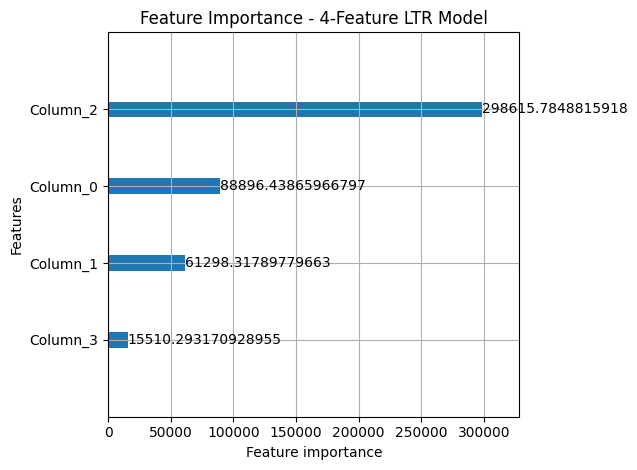

In [36]:
import matplotlib.pyplot as plt

# Plot feature importance by gain
ax=lightgbm.plot_importance(lmart_l_2.booster_, importance_type='gain', max_num_features=10)
# ax.set_yticklabels(feature_names)  # Rename y-axis labels

plt.title("Feature Importance - 4-Feature LTR Model")
plt.tight_layout()
plt.show()


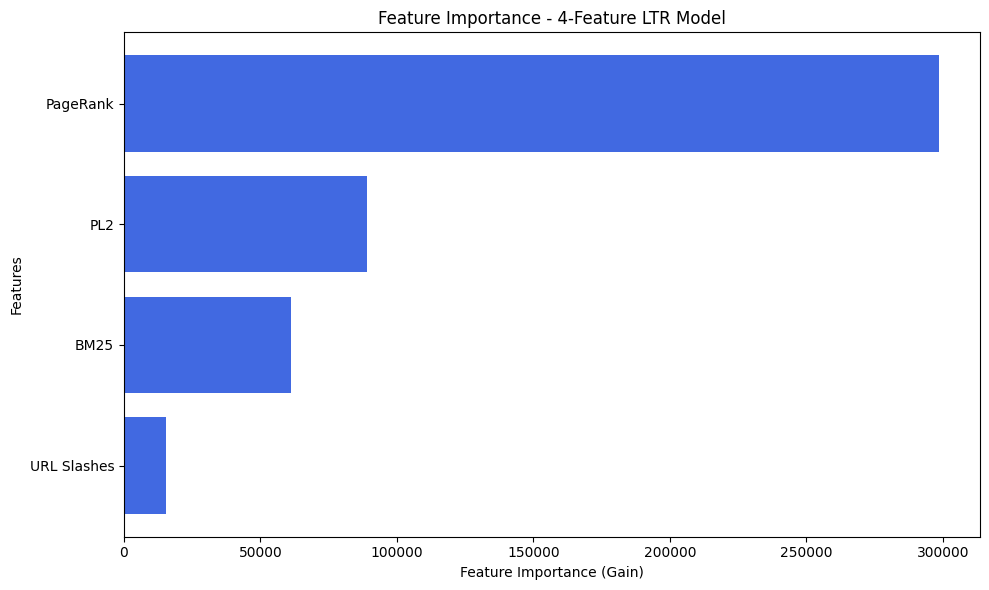

In [37]:
import numpy as np

importance_scores = lmart_l_2.booster_.feature_importance(importance_type="gain")

# Correct feature names mapping
feature_names = ['PL2', 'BM25', 'PageRank', 'URL Slashes']

# Sort features by importance
sorted_idx = np.argsort(importance_scores)
sorted_importance = np.array(importance_scores)[sorted_idx]
sorted_feature_names = np.array(feature_names)[sorted_idx]

# Plot feature importance as a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance, color='royalblue')
plt.xlabel("Feature Importance (Gain)")
plt.ylabel("Features")
plt.title("Feature Importance - 4-Feature LTR Model")
plt.tight_layout()
plt.show()

In [38]:
print("Question 18: URL-slashes feature is at what rank?: 4")

Question 18 : URL-slashes feature is at what rank?: 4


## Q2 (b) URL Type Feature

In this block you should define your URL Type feature and **test it**. **Show clearly all the tests** you have conducted to test that your feature works as expected.

## Quiz Question Q19

In [39]:
#YOUR SOLUTION
from urllib.parse import urlparse

def categorize_url(row):
    """
    Categorizes a URL into:
    0 = missing or invalid
    1 = root (e.g., "", "/", "/index.html")
    2 = subroot (e.g., "/pubs/" or "/pubs/index.html")
    3 = path (e.g., deeper folders like "/pubs/trec9/")
    4 = file (e.g., non-index.html documents or media files)
    """
    url = row.get("url", "")
    if not isinstance(url, str) or url.strip() == "":
        return 0  # missing or invalid

    parsed = urlparse(url)
    path = parsed.path

    if path in ["", "/", "/index.html"]:
        return 1  # root

    path_parts = path.strip("/").split("/")

    if path.endswith("index.html"):
        if len(path_parts) == 2:
            return 2  # subroot
        else:
            return 3  # path
    elif path.endswith("/"):
        if len(path_parts) == 1:
            return 2  # subroot
        else:
            return 3  # path
    else:
        return 4  # file


## Same as test cases in q2a to see the difference in the differnet methods
test_cases_q2b = [
    {"url": "http://trec.nist.gov", "expected": 1},                  # root
    {"url": "http://trec.nist.gov/", "expected": 1},                 # root
    {"url": "http://trec.nist.gov/index.html", "expected": 1},       # root
    {"url": "http://trec.nist.gov/pubs/", "expected": 2},            # subroot
    {"url": "http://trec.nist.gov/pubs/index.html", "expected": 2},  # subroot
    {"url": "http://trec.nist.gov/pubs/trec9/papers/", "expected": 3},   # path
    {"url": "http://trec.nist.gov/pubs/trec9/papers/index.html", "expected": 3},  # path
    {"url": "http://trec.nist.gov/pubs/trec9/t9_proceedings.html", "expected": 4},  # file
    {"url": "http://trec.nist.gov/default.htm", "expected": 4},      # file
    {"url": "", "expected": 0},                                      # invalid
    {"url": None, "expected": 0},                                    # invalid
    {"url": {}, "expected": 0},                                      # invalid
]
# Run tests and assert results
for i, test in enumerate(test_cases_q2b):
    result = categorize_url(test)
    print(f"Test {i+1}: URL={test.get('url', 'missing')}, slashes={result}")
    expected = test.get("expected", 0.0)
    assert result == expected, f"Expected {expected} slashes, got {result}"

print("All URL-slashes feature tests passed!")  # All tests passed


print("\n All tests passed!")


Test 1: URL=http://trec.nist.gov, slashes=1
Test 2: URL=http://trec.nist.gov/, slashes=1
Test 3: URL=http://trec.nist.gov/index.html, slashes=1
Test 4: URL=http://trec.nist.gov/pubs/, slashes=2
Test 5: URL=http://trec.nist.gov/pubs/index.html, slashes=2
Test 6: URL=http://trec.nist.gov/pubs/trec9/papers/, slashes=3
Test 7: URL=http://trec.nist.gov/pubs/trec9/papers/index.html, slashes=3
Test 8: URL=http://trec.nist.gov/pubs/trec9/t9_proceedings.html, slashes=4
Test 9: URL=http://trec.nist.gov/default.htm, slashes=4
Test 10: URL=, slashes=0
Test 11: URL=None, slashes=0
Test 12: URL={}, slashes=0
All URL-slashes feature tests passed!

 All tests passed!


#### (i) URL Type as a PL2 re-ranker

Now you should evaluate your URL type score by re-ranking PL2, without applying learning-to-rank.

Hint:
 - Your reranker should order documents in descending order, i.e. longest URLs first.

You can now answer the corresponding quiz questions.

## Quiz Question Q20-22

In [40]:
## Q 20
#YOUR SOLUTION
url_cat_feature = pt.apply.doc_score(categorize_url,verbose=True)


# New pipleine
url_cat_reranker = firstpass >> url_cat_feature

# Re-rank PL2 results in descending order of URL-slash score
pl2_reranked = url_cat_reranker.search("aaie").sort_values(by="score", ascending=False)

# Display the top-ranked document after re-ranking
print(f"Question 20 : Docno of the top-ranked document for 'aaie': {pl2_reranked.head(1)['docno'].values[0]}")



TerrierRetr(PL2): 0q [00:00, ?q/s]

TerrierRetr(PL2):   0%|          | 0/1 [00:00<?, ?q/s]

pt.apply.doc_score:   0%|          | 0/6 [00:00<?, ?d/s]

Question 20 : Docno of the top-ranked document for 'aaie': G02-80-0379929


In [41]:
## Q21-22

new_pl2_pipeline_2b = url_cat_reranker


eval_new_pl2_2b = pt.Experiment(
    [new_pl2_pipeline_2b], va_topics, va_qrels, ["map", P@5, AP] , round = 4,
)

map_rounded = eval_new_pl2_2b["map"].values[0]
p5_rounded = eval_new_pl2_2b["P@5"].values[0]

print(f"Question 21: Enter the MAP performance of re-ranking PL2 using your URL-category feature implementation : {map_rounded}")
print(f"Question 22: Enter the P@5 performance of re-ranking PL2 using your URL-category feature implementation: {p5_rounded}")


pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

Question 21: Enter the MAP performance of re-ranking PL2 using your URL-category feature implementation : 0.0011
Question 22: Enter the P@5 performance of re-ranking PL2 using your URL-category feature implementation: 0.0


#### (ii) URL Type within an LTR model

Now you should evaluate your URL type score as a feature within a new learned model.

Hint:
 - Carefully consider how to integrate your feature into an LTR model, based on your understanding of how a regression tree works.

You can now answer the corresponding quiz questions.

## Quiz Question Q23-24

In [42]:
#YOUR SOLUTION


stage123_q2b = firstpass >> (stdfeatures ** url_cat_feature)


lmart_l_2_question_2b = lightgbm.LGBMRanker(
    task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10
    )


ltr_four_pipeline_2b =  stage123_q2b >> pt.ltr.apply_learned_model(lmart_l_2_question_2b, form="ltr")


ltr_four_pipeline_2b.fit(tr_topics, tr_qrels, va_topics, va_qrels)

eval_ltr_4_2b = pt.Experiment(
    [ltr_four_pipeline_2b],
    va_topics,
    va_qrels,
    ["map", P@5],
    round = 4
)

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

pt.apply.doc_score:   0%|          | 0/94170 [00:00<?, ?d/s]

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.166667
[2]	valid_0's ndcg@1: 0.296296
[3]	valid_0's ndcg@1: 0.407407
[4]	valid_0's ndcg@1: 0.444444
[5]	valid_0's ndcg@1: 0.537037
[6]	valid_0's ndcg@1: 0.537037
[7]	valid_0's ndcg@1: 0.518519
[8]	valid_0's ndcg@1: 0.574074
[9]	valid_0's ndcg@1: 0.555556
[10]	valid_0's ndcg@1: 0.592593
Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrie

pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [43]:
map_rounded = eval_ltr_4_2b["map"].values[0]
p5_rounded = eval_ltr_4_2b["P@5"].values[0]
print(f"Question 23: Enter the MAP performance of the resulting LTR model with 4 features. : {map_rounded}")
print(f"Question 24: Enter the P@5 performance of the resulting LTR model with 4 features: {p5_rounded}")

Question 23: Enter the MAP performance of the resulting LTR model with 4 features. : 0.5086
Question 24: Enter the P@5 performance of the resulting LTR model with 4 features: 0.1333


In [44]:
#YOUR SOLUTION

# Compare models per query
per_query_results = pt.Experiment(
    [lmart_l_pipe, ltr_four_pipeline_2b],
    test_topics,
    test_qrels,
    eval_metrics=["map", P@5],
    names=["LTR_3", "LTR_4"],
    round=4,
    perquery=True,
)

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Quiz Question Q25-26

In [46]:
import pandas as pd

# Filter data for LTR_3 and LTR_4
ltr3 = per_query_results[per_query_results["name"] == "LTR_3"]
ltr4 = per_query_results[per_query_results["name"] == "LTR_4"]

# Merge both models' results on query id (qid) and measure (map/P@5)
comparison_df = ltr3.merge(ltr4, on=["qid", "measure"], suffixes=("_ltr3", "_ltr4"))

# Count queries where LTR_4 improved over LTR_3
ap_improved_queries = (comparison_df["measure"] == "map") & (comparison_df["value_ltr4"] > comparison_df["value_ltr3"])
p5_improved_queries = (comparison_df["measure"] == "P@5") & (comparison_df["value_ltr4"] > comparison_df["value_ltr3"])

num_ap_improved = ap_improved_queries.sum()
num_p5_improved = p5_improved_queries.sum()

# Print results
print(f"Question 25: Number of queries improved in AP (map): {num_ap_improved}")
print(f"Question 26: Number of queries improved in P@5: {num_p5_improved}")

Question 25: Number of queries improved in AP (map): 29
Question 26: Number of queries improved in P@5: 11


## Quiz Question Q27-28

In [48]:
# Filter for MAP
map_scores_ltr3 = comparison_df[(comparison_df["measure"] == "map")]["value_ltr3"]
map_scores_ltr4 = comparison_df[(comparison_df["measure"] == "map")]["value_ltr4"]

# Filter for P@5
p5_scores_ltr3 = comparison_df[(comparison_df["measure"] == "P@5")]["value_ltr3"]
p5_scores_ltr4 = comparison_df[(comparison_df["measure"] == "P@5")]["value_ltr4"]

# Paired t-tests
pval_map = round(ttest_rel(map_scores_ltr4, map_scores_ltr3).pvalue, 4)
pval_p5 = round(ttest_rel(p5_scores_ltr4, p5_scores_ltr3).pvalue, 4)

# Output results
print(f"Question 27: P-value for MAP (AP) t-test: {pval_map}")
print(f"Question 28: P-value for P@5 t-test: {pval_p5}")

Question 27: P-value for MAP (AP) t-test: 0.0023
Question 28: P-value for P@5 t-test: 0.0588


## Quiz Question Q29-30

In [50]:
if pval_map < 0.05:
    print("Question 29: True")  # Statistically significant improvement
else:
    print("Question 29: False")  # No significant improvement

Question 29: True


In [51]:
if pval_p5 < 0.05:
    print("Question 30: True")  # Statistically significant improvement
else:
    print("Question 30: False")  # No significant improvement

Question 30: False


## Quiz Question 31) Visualisation Proof

In [52]:
print(lmart_l_2_question_2b.booster_.feature_name())

['Column_0', 'Column_1', 'Column_2', 'Column_3']


In [53]:
feature_names = ['PL2', 'BM25', 'PageRank', 'URL Slashes']

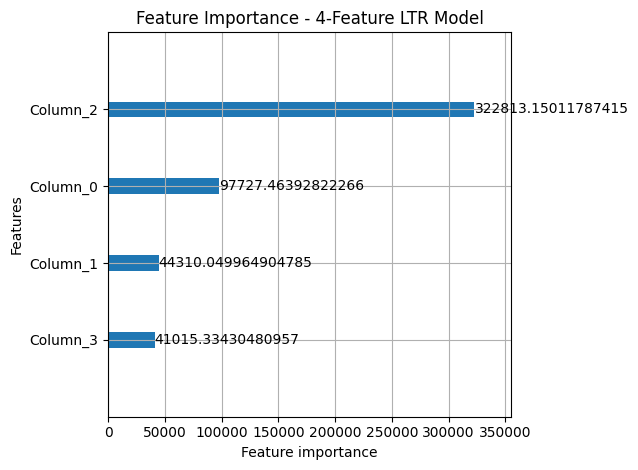

In [54]:
import matplotlib.pyplot as plt

# Plot feature importance by gain
ax=lightgbm.plot_importance(lmart_l_2_question_2b.booster_, importance_type='gain', max_num_features=10)
# ax.set_yticklabels(feature_names)  # Rename y-axis labels

plt.title("Feature Importance - 4-Feature LTR Model")
plt.tight_layout()
plt.show()


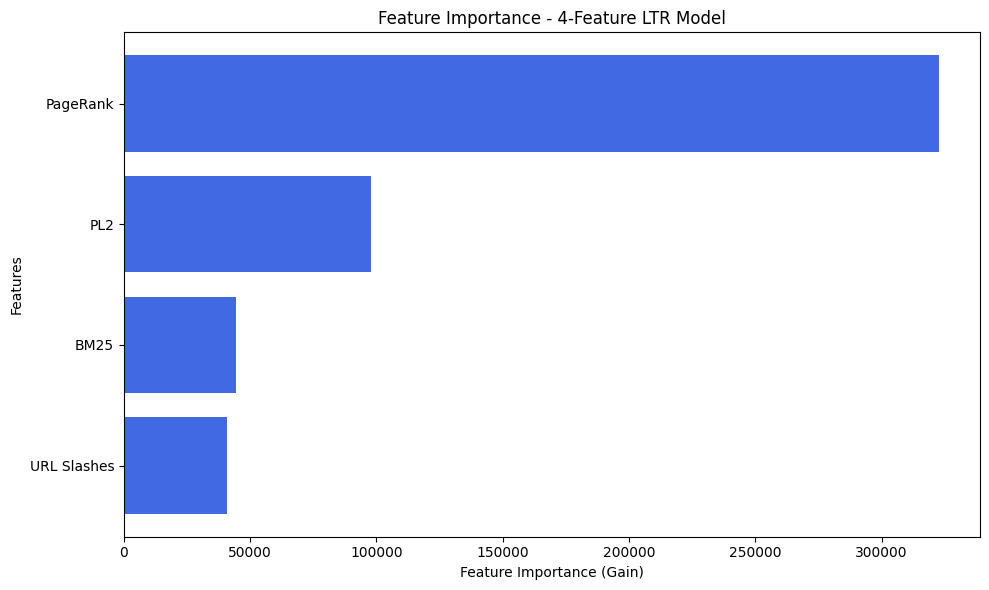

In [55]:
import numpy as np

importance_scores = lmart_l_2_question_2b.booster_.feature_importance(importance_type="gain")

# Correct feature names mapping
feature_names = ['PL2', 'BM25', 'PageRank', 'URL Slashes']

# Sort features by importance
sorted_idx = np.argsort(importance_scores)
sorted_importance = np.array(importance_scores)[sorted_idx]
sorted_feature_names = np.array(feature_names)[sorted_idx]

# Plot feature importance as a horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_importance, color='royalblue')
plt.xlabel("Feature Importance (Gain)")
plt.ylabel("Features")
plt.title("Feature Importance - 4-Feature LTR Model")
plt.tight_layout()
plt.show()

## Quiz Question 32


### Neither – both instantiations do not significantly improve the baseline



# Q3 Proximity Search Feature

Now you will implement a new query-dependent feature, using the MinDist() function, as discussed in the specification. Do carefully **read the Exercise 2 specification** before starting the implementation.

Hints:
 - Again, remember to use assertions to **test** your feature implementations.
 - Refer to the PyTerrier learning to rank documentation concerning `features_importances_` for obtaining feature importances
 - For tokenisation of queries and documents, you can simply use Python's [`str.split()`](https://docs.python.org/3.3/library/stdtypes.html#str.split), without any arguments. Do not use any external libraries.

As mentioned in the specification, you should implement a function called `avgmindist()`, which takes the text of the query and the text of the document, and returns a score for the document, i.e. it must conform to the following Python specification:
```python
def avgmindist(query : str, document : str) -> float
```

**NB**: There are particular specific requirements for your implementations of MinDist() and avgmindist() that are detailed in the specification.

## Quiz Question 33)

In [57]:
def avgmindist(query: str, document: str) -> float:
    punctuation = "!()-[]{};:'\",<>./?@#$%^&*_~"

    # Convert to lowercase
    query = query.lower()
    document = document.lower()

    # Manually remove punctuation
    for p in punctuation:
        document = document.replace(p, '')

    # Tokenise query and document
    doc_tokens = document.split()
    query_terms = query.split()

    # Record positions of query terms in the document
    term_positions = {}
    for term in query_terms:
        term_positions[term] = []

    for idx, token in enumerate(doc_tokens):
        if token in term_positions:
            term_positions[token].append(idx)

    # Extract query terms that were found in the document
    found_terms = [term for term in query_terms if term_positions[term]]

    # If fewer than 2 terms found, return document length
    if len(found_terms) < 2:
        return len(doc_tokens)

    # Compute minimum distances between adjacent query term pairs
    min_dists = []
    for i in range(len(found_terms) - 1):
        positions1 = term_positions[found_terms[i]]
        positions2 = term_positions[found_terms[i + 1]]
        # Efficient min distance computation without building full list
        min_dist = len(doc_tokens)  # upper bound
        for p1 in positions1:
            for p2 in positions2:
                dist = abs(p1 - p2)
                if dist < min_dist:
                    min_dist = dist
        min_dists.append(min_dist)

    # Return average of minimum distances
    return sum(min_dists) / len(min_dists)


In [58]:
## Test cases for avgmindist to validate different proximity situations
test_cases_avgmindist = [
    {"query": "new york", "document": "I love new york", "expected": 1},  # adjacent terms
    {"query": "new york", "document": "new things in the middle then comes york", "expected": 7},  # distant terms
    {"query": "new york city", "document": "new stuff far away from york and even farther city", "expected": 4.5},  # 3 terms
    {"query": "apple banana", "document": "apple pie is delicious", "expected": 4},  # one term only
    {"query": "banana mango", "document": "this document has neither of them", "expected": 6},  # no matching terms
    {"query": "hello world", "document": "Hello, this is the real world!", "expected": 5},  # punctuation removed
    {"query": "ai ml", "document": "ml ai ai ml", "expected": 1},  # repeated terms
    {"query": "ai", "document": "ai is popular in tech", "expected": 5},  # single term
    {"query": "data science", "document": "I study data science.", "expected": 1},  # phrase match
]

# Run test cases and assert results
for i, test in enumerate(test_cases_avgmindist):
    result = avgmindist(test["query"], test["document"])
    print(f"Test {i+1}: Query='{test['query']}', Document='{test['document']}' , Result={result}")
    assert result == test["expected"], f"Test {i+1} failed. Expected {test['expected']}, got {result}"

print("\nAll avgmindist tests passed.")

Test 1: Query='new york', Document='I love new york' , Result=1.0
Test 2: Query='new york', Document='new things in the middle then comes york' , Result=7.0
Test 3: Query='new york city', Document='new stuff far away from york and even farther city' , Result=4.5
Test 4: Query='apple banana', Document='apple pie is delicious' , Result=4
Test 5: Query='banana mango', Document='this document has neither of them' , Result=6
Test 6: Query='hello world', Document='Hello, this is the real world!' , Result=5.0
Test 7: Query='ai ml', Document='ml ai ai ml' , Result=1.0
Test 8: Query='ai', Document='ai is popular in tech' , Result=5
Test 9: Query='data science', Document='I study data science.' , Result=1.0

All avgmindist tests passed.


## Quiz Question 34)

#### Explaination of the above code =>
EXPLANATION OF THE CODE:
1. The code first converts the query and document to lowercase. Then it removes punctuation from the document using a manually defined list of characters, without using any external libraries.
2. The document and query are tokenised using split(). A dictionary is defined to store the positions of each query term found in the document.
3. The function checks for query terms that are actually present and computes all possible distances between adjacent term pairs. For each pair, it finds the minimum distance.
4. The final score is the average of all minimum distances between sequential query terms.
If less than two query terms match, the function returns the document length as a fallback.



DESIGN CHOICES:
1. A custom punctuation list is used to clean the document without relying on any external libraries.
2. The function returns the document length if less than two query terms are found, to handle edge cases and follow spec.
3. A dictionary-based lookup is used to efficiently store the positions of query terms.
4. Nested loops are used to compute all pairwise distances between adjacent query terms


You should test your impementation yourself (your code must list along your code *all* the test cases you deployed to test that your feature works as expected). In addition, to also allow us to verify your implementation, we have created 9 testcases. Please run `run_test_cases()` and use its responses to answer the relevant quiz questions.

Hint:
 - Our test cases took around 1-3ms each. If the testing of your implementation takes magnitudes of time longer, then this will impact upon how long it takes you to train and evaluate your implementation within a LTR pipeline.


## Quiz Question 35-43

In [59]:
#DO NOT ALTER THIS CELL
TEST_CASES = [
  ('fermilab directory', 45, 567257), #1
  ('webcam', 45, 567257), #2
  ('DOM surface', 384034, 388292), #3
  ('DOM surface', 45, 384034), #4
  ('DOM surface document', 388292, 384034), #5
  ('DOM software AMANDA', 639302, 384034), #6
  ('fermilab directory', 388292, 384034), #7
  ('trigger data', 596532, 639302), #8
  ('underlying hardware', 384034, 333649) #9
]

def run_test_cases():
  import datetime
  docno=0
  body=3
  for i, (query, docid1, docid2) in enumerate(TEST_CASES):
    start = datetime.datetime.now()
    meta1 = index.getMetaIndex().getAllItems(docid1)
    meta2 = index.getMetaIndex().getAllItems(docid2)
    s1 = avgmindist(query, meta1[body])
    s2 = avgmindist(query, meta2[body])
    if s1 > s2:
      result = meta1[docno]
      cmpD = "%s > %s" % (meta1[docno],meta2[docno])
    elif s2 > s1:
      result = meta2[docno]
      cmpD = "%s > %s" % (meta2[docno],meta1[docno])
    else:
      result = "EQUAL"
      cmpD = "%s == %s" % (meta1[docno],meta2[docno])
    end = datetime.datetime.now()
    print("TEST CASE %d result %s time %d ms" % (i+1, result, float((end-start).microseconds)/1000.))

run_test_cases()

TEST CASE 1 result G20-36-1335992 time 1 ms
TEST CASE 2 result G20-36-1335992 time 0 ms
TEST CASE 3 result G13-80-1271020 time 0 ms
TEST CASE 4 result G00-00-0478398 time 0 ms
TEST CASE 5 result G13-80-1271020 time 1 ms
TEST CASE 6 result G23-17-3674898 time 0 ms
TEST CASE 7 result G13-80-1271020 time 0 ms
TEST CASE 8 result G21-44-1000362 time 0 ms
TEST CASE 9 result G11-79-2454097 time 0 ms


You should now integrate your avgmindist() function into a new LTR model, and compare its MAP & P@5 performance to the LTR baseline. You can now answer the corresponding quiz questions.

## Question 44

In [60]:
avgmindist_feature = pt.apply.doc_score(lambda row: avgmindist(row["query"], row["docno"]),verbose=True)


In [61]:
#YOUR SOLUTION


stage123_q3 = firstpass >> (stdfeatures ** avgmindist_feature)


lmart_l_2_question_3 = lightgbm.LGBMRanker(
    task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10
    )


ltr_four_pipeline_3 =  stage123_q3 >> pt.ltr.apply_learned_model(lmart_l_2_question_3, form="ltr")


ltr_four_pipeline_3.fit(tr_topics, tr_qrels, va_topics, va_qrels)

eval_ltr_4_q3 = pt.Experiment(
    [ltr_four_pipeline_3],
    va_topics,
    va_qrels,
    ["map", P@5],
    round = 4
)


Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

pt.apply.doc_score:   0%|          | 0/94170 [00:00<?, ?d/s]

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.148148
[2]	valid_0's ndcg@1: 0.203704
[3]	valid_0's ndcg@1: 0.333333
[4]	valid_0's ndcg@1: 0.351852
[5]	valid_0's ndcg@1: 0.37037
[6]	valid_0's ndcg@1: 0.37037
[7]	valid_0's ndcg@1: 0.388889
[8]	valid_0's ndcg@1: 0.407407
[9]	valid_0's ndcg@1: 0.425926
[10]	valid_0's ndcg@1: 0.425926
Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.

pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [62]:
map_rounded = eval_ltr_4_q3["map"].values[0]
print(f"Question 44: Enter the MAP performance of the resulting LTR model with 4 features. : {map_rounded}")

Question 44: Enter the MAP performance of the resulting LTR model with 4 features. : 0.3135


## Question 45

In [63]:
# Compare models per query
p5_results = pt.Experiment(
    [ltr_four_pipeline_3],
    test_topics,
    test_qrels,
    eval_metrics=[P@5],
    round=4,
)

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [64]:
map_rounded = p5_results["P@5"].values[0]
print(f"Question 45(a): Enter the MAP performance of the resulting LTR model with 4 features. : {map_rounded}")

Question 45(a): Enter the MAP performance of the resulting LTR model with 4 features. : 0.1013


In [65]:
#YOUR SOLUTION

# Compare models per query
per_query_results = pt.Experiment(
    [lmart_l_pipe, ltr_four_pipeline_3],
    test_topics,
    test_qrels,
    eval_metrics=["map"],
    names=["LTR_3", "LTR_4"],
    round=4,
    perquery=True,
)

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [66]:
# Analyze per-query performance
ltr3_results = per_query_results[per_query_results["name"] == "LTR_3"].rename(columns={"value": "map_ltr3"})
ltr4_results = per_query_results[per_query_results["name"] == "LTR_4"].rename(columns={"value": "map_ltr4"})

# Merge results by query ID
query_deltas = ltr3_results.merge(ltr4_results, on="qid")

# Compute change in AP
query_deltas["delta_AP"] = query_deltas["map_ltr4"] - query_deltas["map_ltr3"]

# Count improved and degraded queries
improved_queries = (query_deltas["delta_AP"] > 0).sum()
degraded_queries = (query_deltas["delta_AP"] < 0).sum()

print(f"Question 45(b) Queries Improved: {improved_queries}, Question 45(c) Queries Degraded: {degraded_queries}")

Question 45(b) Queries Improved: 0, Question 45(c) Queries Degraded: 0


# Q4 A 5-feature Learning-to-Rank Model

You will now experiment with the LightGBM LambdaMART technique where you include both your added features (URL Type and AvgMinDist) along with the 3 initial features inc the initial PL2 candidate set (5 features in total).

You need to learn a *new* model when using your final selection of 5 features.

Evaluate the performance of your resulting LTR system in comparison to the LTR baseline and answer the quiz questions. For ease of comparison and readability, you should also display your results for the performance of the 4-feature LTR models.

In [67]:
#YOUR SOLUTION

stage1234 = firstpass >> (stdfeatures ** url_cat_feature ** avgmindist_feature)


question_4 = lightgbm.LGBMRanker(
    task="train",
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=100,
    max_bin=255,
    num_leaves=7,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[1, 3, 5, 10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=10
    )


question_4_pipeline =  stage1234 >> pt.ltr.apply_learned_model(question_4, form="ltr")


question_4_pipeline.fit(tr_topics, tr_qrels, va_topics, va_qrels)

eval_ltr_5 = pt.Experiment(
    [question_4_pipeline],
    va_topics,
    va_qrels,
    ["map", P@5],
    round = 4
)


Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

pt.apply.doc_score:   0%|          | 0/94170 [00:00<?, ?d/s]

pt.apply.doc_score:   0%|          | 0/94170 [00:00<?, ?d/s]

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's ndcg@1: 0.166667
[2]	valid_0's ndcg@1: 0.296296
[3]	valid_0's ndcg@1: 0.407407
[4]	valid_0's ndcg@1: 0.444444
[5]	valid_0's ndcg@1: 0.537037
[6]	valid_0's ndcg@1: 0.537037
[7]	valid_0's ndcg@1: 0.518519
[8]	valid_0's ndcg@1: 0.574074
[9]	valid_0's ndcg@1: 0.555556
[10]	valid_0's ndcg@1: 0.592593
Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrie

pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

pt.apply.doc_score:   0%|          | 0/53209 [00:00<?, ?d/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Question 46

In [68]:
map_rounded = eval_ltr_5["map"].values[0]
print(f"Question 46: Enter the MAP performance of the resulting LTR model with 4 features. : {map_rounded}")

Question 46: Enter the MAP performance of the resulting LTR model with 4 features. : 0.5086


## Question 47

In [69]:
# Compare models per query
p5_results = pt.Experiment(
    [question_4_pipeline],
    test_topics,
    test_qrels,
    eval_metrics=["map",P@5],
    round=4,
)

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [70]:
map_rounded = p5_results["P@5"].values[0]
print(f"Question 47(a): Enter the P@5 performance of the resulting LTR model with 5 features. : {map_rounded}")

Question 47(a): Enter the P@5 performance of the resulting LTR model with 5 features. : 0.1227


In [71]:
#YOUR SOLUTION

# Compare models per query
per_query_results = pt.Experiment(
    [lmart_l_pipe, question_4_pipeline],
    test_topics,
    test_qrels,
    eval_metrics=["map"],
    names=["LTR_3", "LTR_5"],
    round=4,
    perquery=True,
)

Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Sqlite3ScorerCache('features-cache', TerrierFeatRetr(/root/.pyterrier/corpora/50pct/index/ex3/data.properties,['SAMPLE', 'WMODEL:SingleFieldModel(BM25,0)', 'QI:StaticFeature(OIS,/root/.pyterrier/corpora/50pct/index/ex3/data-pagerank.oos)'],{'terrierql': 'on', 'parsecontrols': 'on', 'parseql': 'on', 'applypipeline': 'on', 'localmatching': 'on', 'filters': 'on', 'decorate': 'on', 'matching': 'FatFeaturedScoringMatching,org.terrier.matching.daat.FatFull', 'decorate_batch': 'on'},{'querying.processes': 'terrierql:TerrierQLParser,parsecontrols:TerrierQLToControls,parseql:TerrierQLToMatchingQueryTerms,matchopql:MatchingOpQLParser,applypipeline:ApplyTermPipeline,context_wmodel:org.terrier.python.WmodelFromContextProcess,localmatching:LocalManager$ApplyLocalMatching,qe:QueryExpansion,labels:org.terrier.learning.LabelDecorator,filters:LocalManager$PostFilterProcess,decorate:SimpleDecorateProcess', 'querying.postfilters': 'decorate:SimpleDecorate,site:SiteFilter,scope:Scope', 'querying.default.c

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

pt.apply.doc_score:   0%|          | 0/74229 [00:00<?, ?d/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [72]:
# Analyze per-query performance
ltr3_results = per_query_results[per_query_results["name"] == "LTR_3"].rename(columns={"value": "map_ltr3"})
ltr5_results = per_query_results[per_query_results["name"] == "LTR_5"].rename(columns={"value": "map_ltr5"})

# Merge results by query ID
query_deltas = ltr3_results.merge(ltr5_results, on="qid")

# Compute change in AP
query_deltas["delta_AP"] = query_deltas["map_ltr5"] - query_deltas["map_ltr3"]

# Count improved and degraded queries
improved_queries = (query_deltas["delta_AP"] > 0).sum()
degraded_queries = (query_deltas["delta_AP"] < 0).sum()

print(f"Question 47(b) Queries Improved: {improved_queries}, Question 47(c) Queries Degraded: {degraded_queries}")

Question 47(b) Queries Improved: 29, Question 47(c) Queries Degraded: 22


## Question 48


In [73]:
map_rounded = p5_results["map"].values[0]
print(f" Enter the MAP performance of the resulting LTR model with 5 features. : {map_rounded}")

 Enter the MAP performance of the resulting LTR model with 5 features. : 0.4765


### a.It is better than the AvgMinDist 4-features LTR  model

## Question 49


## b. False

## Question 50


###  a. The normalisation of feature scores does matter in LambdaMART

### b. It depends on the features; sometimes normalisation matters sometimes it does not

### c. The sign (positive or negative) of feature values does matter in  LambdaMART

### f. It depends on the features; sometimes the sign of the feature values (positive or negative) matters sometimes it does not

## Question 51

### c. AvgMinDist does not benefit any query

## Question 52

### b. Informational

## Question 53

### c. Max

## Question 54


### Consider your other intuitions about navigational search tasks. Name one other type of evidence you have not used in your deployed system, which typically helps improve navigational search effectiveness.



### anchor text analysis

# That's all Folks

**Submission Instructions:** Complete this notebook. All your answers to Exercise 2 must be submitted on the Exercise 2 Quiz instance on Moodle with your completed notebook (showing **both your solutions and the results of their executions**). Only answers submitted through the Quiz are marked though. Marks can be lost if the notebook does not **show evidence** for the reported answers in the quiz.

While students are asked to submit their solutions through a Quiz, marking will be done with a “human-in-the-loop” and partial marks are awarded depending on the quality of the submitted work.

Your answers to the Quiz questions along with your .ipynb notebook file (showing code and outputs) must be submitted by the stated Exercise 2 deadline.